In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

sns.set(context="notebook", style="whitegrid")
RNG = 42
TRAINING_DATA_SURPRISE_DATA = "./data/training_data_surprise_model"

# Link transform (for bounded [-1,1] predictions)
_EPS = 1e-6
def y_to_z(y):
    y_ = np.clip(y, -1 + _EPS, 1 - _EPS)
    return np.arctanh(y_)
def z_to_y(z):
    return np.clip(np.tanh(z), -1.0, 1.0)

# Metrics
def report_metrics(y_true, y_pred, label=""):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    evs  = explained_variance_score(y_true, y_pred)
    print(f"{label}RMSE={rmse:.4f} | MAE={mae:.4f} | R^2={r2:.4f} | EVS={evs:.4f}")
    return dict(rmse=rmse, mae=mae, r2=r2, evs=evs)

def concat_years(start_year: int, end_year: int, base_dir: str):
    """
    Concatenate yearly parquet files into a single DataFrame.
    
    Parameters
    ----------
    start_year : int
        First year (inclusive).
    end_year : int
        Last year (inclusive).
    base_dir : str
        Path to the directory containing parquet files.
    
    Returns
    -------
    pd.DataFrame
        Combined DataFrame of all years.
    """
    dfs = []
    for year in range(start_year, end_year + 1):
        path = os.path.join(base_dir, f"{year}_mgmt_training_10K.parquet")
        if os.path.exists(path):
            year_df = pd.read_parquet(path, engine="fastparquet")
            dfs.append(year_df)
        else:
            print(f"⚠️ Skipping missing file: {path}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


In [55]:
# df = pd.read_parquet("../../data/training_data_surprise_model/2005_mgmt_training_10Q.parquet", engine="fastparquet")
df = concat_years(2005, 2013, "../../data/training_data_surprise_model")

# X = np.vstack(df["mgmt_embedding"].values).astype(np.float32)
# y = df["ni_be"].to_numpy(np.float32)

# y = np.clip(y, -1, 1)   # enforce bounds
# z = y_to_z(y)           # latent transform

# X_train, X_test, z_train, z_test, y_train, y_test = train_test_split(
#     X, z, y, test_size=0.2, random_state=RNG
# )
# X_train.shape, X_test.shape

In [57]:
# Ensure "date" is string and extract the year
df["year"] = df["date"].astype(str).str[:4].astype(int)

# Training: 2005–2011
train_df = df[df["year"].between(2005, 2011)]

# Testing: 2012–2023
test_df  = df[df["year"].between(2012, 2012)]

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

# Build feature/target arrays
X_train = np.vstack(train_df["mgmt_embedding"].values).astype(np.float32)
y_train = train_df["ni_be"].to_numpy(np.float32)

X_test  = np.vstack(test_df["mgmt_embedding"].values).astype(np.float32)
y_test  = test_df["ni_be"].to_numpy(np.float32)

# Enforce bounds + latent transform
y_train = np.clip(y_train, -1, 1)
y_test  = np.clip(y_test, -1, 1)

z_train = y_to_z(y_train)
z_test  = y_to_z(y_test)

X_train.shape, X_test.shape


Train shape: (24077, 6)
Test shape : (3174, 6)


((24077, 768), (3174, 768))

## Model 1

In [58]:
depths = list(range(2, 42, 2))
results = []

for idx, d in enumerate(depths):
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=d,
        min_samples_leaf=5,
        min_samples_split=10,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=RNG,
    )
    print(f"Training with max depth {depths[idx]}")
    rf.fit(X_train, z_train)
    y_te_pred = z_to_y(rf.predict(X_test))
    test_rmse = root_mean_squared_error(y_test, y_te_pred)
    results.append({"max_depth": d, "model": rf, "test_rmse": test_rmse})
    print(f"Finished Training {rf}")

# Pick best
best_entry = min(results, key=lambda x: x["test_rmse"])
best_model = best_entry["model"]
best_depth = best_entry["max_depth"]

print(f"Best model: max_depth={best_depth} with Test RMSE={best_entry['test_rmse']:.4f}")


Training with max depth 2
Finished Training RandomForestRegressor(max_depth=2, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=400, n_jobs=-1,
                      random_state=42)
Training with max depth 4
Finished Training RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=400, n_jobs=-1,
                      random_state=42)
Training with max depth 6
Finished Training RandomForestRegressor(max_depth=6, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=400, n_jobs=-1,
                      random_state=42)
Training with max depth 8
Finished Training RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=400, n_jobs=-1,
                      random_state=42)
Training with max depth 10
Finished Training RandomForestRegressor(max_d

In [59]:
y_tr_pred = z_to_y(best_model.predict(X_train))
y_te_pred = z_to_y(best_model.predict(X_test))

print("== Train metrics ==")
train_stats = report_metrics(y_train, y_tr_pred)

print("\n== Test metrics ==")
test_stats = report_metrics(y_test, y_te_pred)


== Train metrics ==
RMSE=0.3179 | MAE=0.2616 | R^2=0.0633 | EVS=0.4310

== Test metrics ==
RMSE=0.3847 | MAE=0.3064 | R^2=-0.6025 | EVS=0.0239


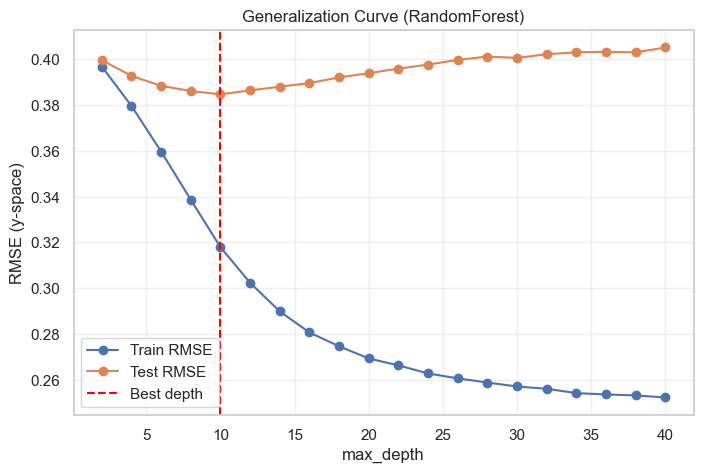

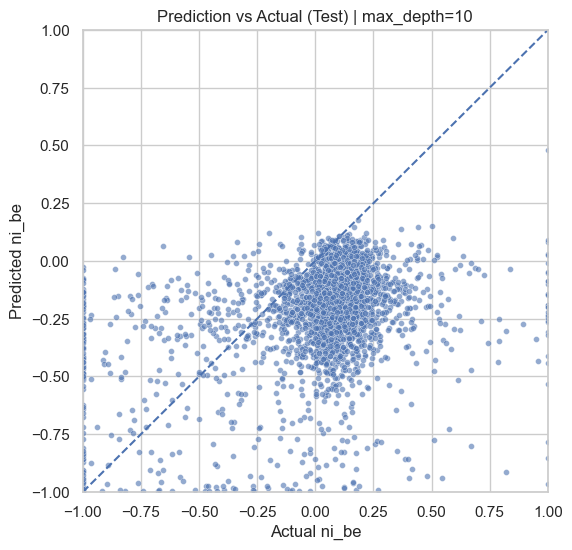

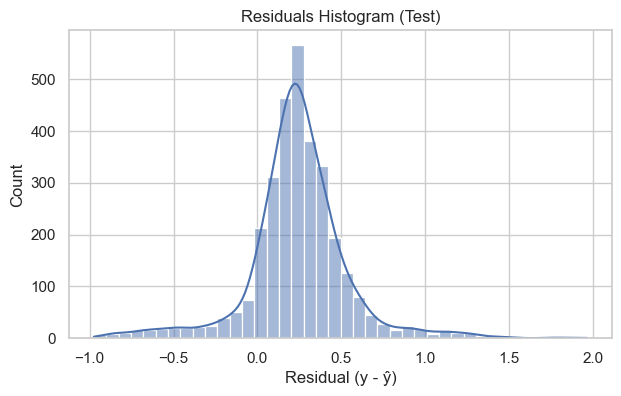

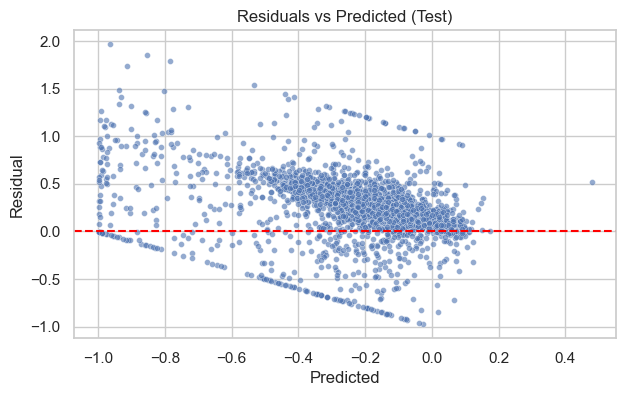

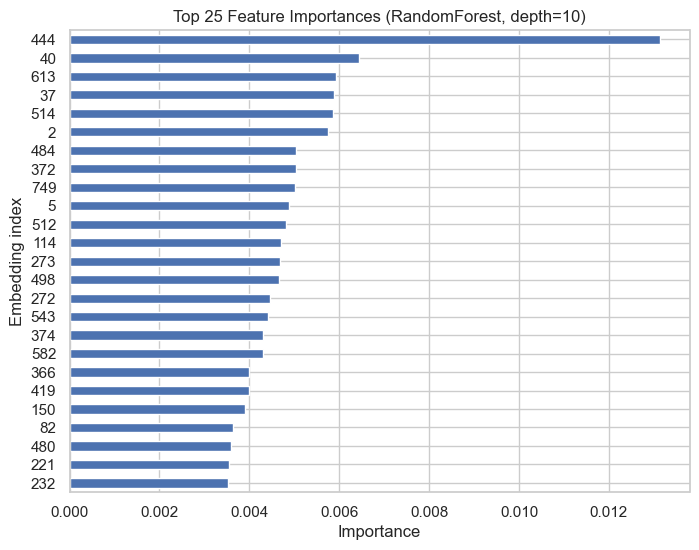

In [60]:
# 1. Generalization curve (Train vs Test RMSE)
train_rmses = [root_mean_squared_error(y_train, z_to_y(m["model"].predict(X_train))) for m in results]
test_rmses  = [m["test_rmse"] for m in results]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(depths, train_rmses, marker="o", label="Train RMSE")
ax.plot(depths, test_rmses,  marker="o", label="Test RMSE")
ax.axvline(best_depth, color="red", linestyle="--", label="Best depth")
ax.set_xlabel("max_depth")
ax.set_ylabel("RMSE (y-space)")
ax.set_title("Generalization Curve (RandomForest)")
ax.legend(); ax.grid(True, alpha=0.3)
plt.show()

# 2. Prediction vs Actual (Test)
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_te_pred, alpha=0.6, s=18, ax=ax)
lims = [-1, 1]
ax.plot(lims, lims, "--")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("Actual ni_be"); ax.set_ylabel("Predicted ni_be")
ax.set_title(f"Prediction vs Actual (Test) | max_depth={best_depth}")
plt.show()

# 3. Residual histogram
res = y_test - y_te_pred
fig, ax = plt.subplots(figsize=(7,4))
sns.histplot(res, bins=40, kde=True, ax=ax)
ax.set_title("Residuals Histogram (Test)")
ax.set_xlabel("Residual (y - ŷ)")
plt.show()

# 4. Residuals vs Predicted
fig, ax = plt.subplots(figsize=(7,4))
sns.scatterplot(x=y_te_pred, y=res, alpha=0.6, s=18, ax=ax)
ax.axhline(0, ls="--", color="red")
ax.set_title("Residuals vs Predicted (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")
plt.show()

# 5. Feature importances (Top 25)
imp = pd.Series(best_model.feature_importances_)
fig, ax = plt.subplots(figsize=(8,6))
imp.sort_values(ascending=False).head(25).iloc[::-1].plot(kind="barh", ax=ax)
ax.set_title(f"Top 25 Feature Importances (RandomForest, depth={best_depth})")
ax.set_xlabel("Importance")
ax.set_ylabel("Embedding index")
plt.show()


In [61]:
depths = list(range(2, 42, 2))
results = []

for idx, d in enumerate(depths):
    rf = RandomForestRegressor(
        n_estimators=750,
        max_depth=d,
        min_samples_leaf=5,
        min_samples_split=10,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=RNG,
    )
    print(f"Training with max depth {depths[idx]}")
    rf.fit(X_train, z_train)
    y_te_pred = z_to_y(rf.predict(X_test))
    test_rmse = root_mean_squared_error(y_test, y_te_pred)
    results.append({"max_depth": d, "model": rf, "test_rmse": test_rmse})
    print(f"Finished Training {rf}")

# Pick best
best_entry = min(results, key=lambda x: x["test_rmse"])
best_model = best_entry["model"]
best_depth = best_entry["max_depth"]

print(f"Best model: max_depth={best_depth} with Test RMSE={best_entry['test_rmse']:.4f}")


Training with max depth 2
Finished Training RandomForestRegressor(max_depth=2, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=750, n_jobs=-1,
                      random_state=42)
Training with max depth 4
Finished Training RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=750, n_jobs=-1,
                      random_state=42)
Training with max depth 6
Finished Training RandomForestRegressor(max_depth=6, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=750, n_jobs=-1,
                      random_state=42)
Training with max depth 8
Finished Training RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=750, n_jobs=-1,
                      random_state=42)
Training with max depth 10
Finished Training RandomForestRegressor(max_d

In [62]:
y_tr_pred = z_to_y(best_model.predict(X_train))
y_te_pred = z_to_y(best_model.predict(X_test))

print("== Train metrics ==")
train_stats = report_metrics(y_train, y_tr_pred)

print("\n== Test metrics ==")
test_stats = report_metrics(y_test, y_te_pred)


== Train metrics ==
RMSE=0.3174 | MAE=0.2613 | R^2=0.0666 | EVS=0.4339

== Test metrics ==
RMSE=0.3842 | MAE=0.3062 | R^2=-0.5982 | EVS=0.0264


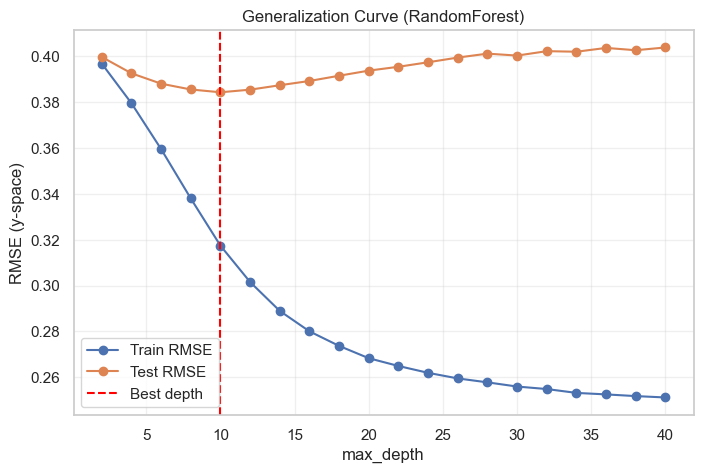

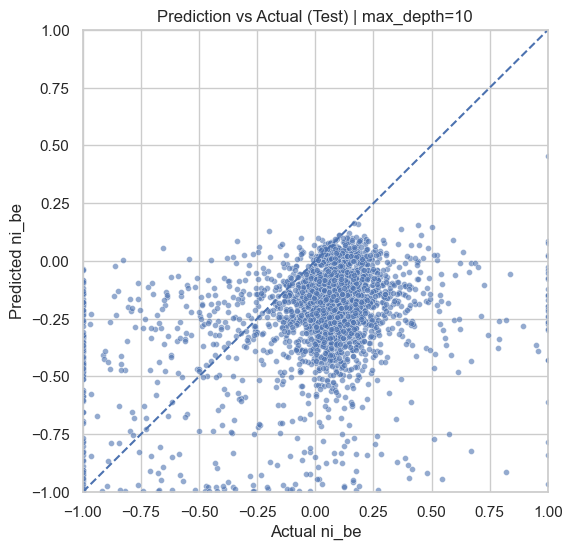

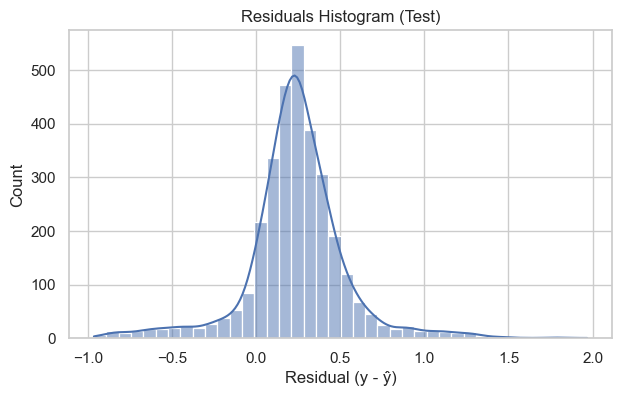

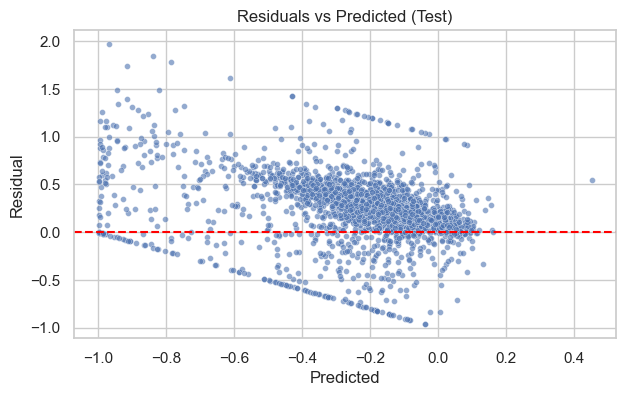

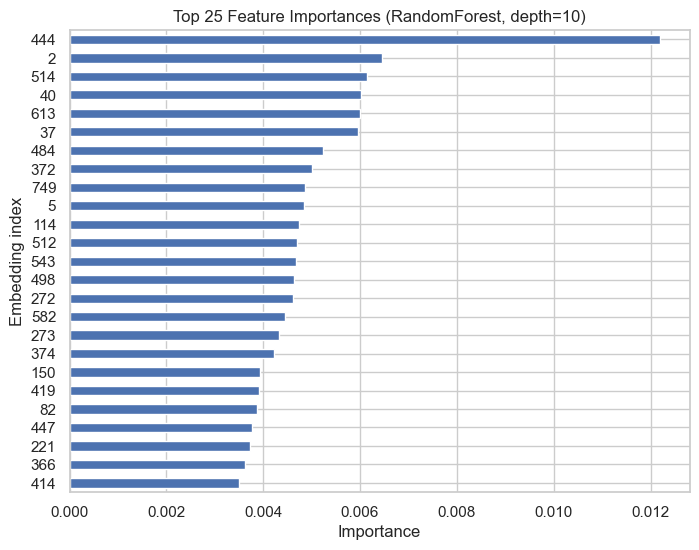

In [63]:
# 1. Generalization curve (Train vs Test RMSE)
train_rmses = [root_mean_squared_error(y_train, z_to_y(m["model"].predict(X_train))) for m in results]
test_rmses  = [m["test_rmse"] for m in results]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(depths, train_rmses, marker="o", label="Train RMSE")
ax.plot(depths, test_rmses,  marker="o", label="Test RMSE")
ax.axvline(best_depth, color="red", linestyle="--", label="Best depth")
ax.set_xlabel("max_depth")
ax.set_ylabel("RMSE (y-space)")
ax.set_title("Generalization Curve (RandomForest)")
ax.legend(); ax.grid(True, alpha=0.3)
plt.show()

# 2. Prediction vs Actual (Test)
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_te_pred, alpha=0.6, s=18, ax=ax)
lims = [-1, 1]
ax.plot(lims, lims, "--")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("Actual ni_be"); ax.set_ylabel("Predicted ni_be")
ax.set_title(f"Prediction vs Actual (Test) | max_depth={best_depth}")
plt.show()

# 3. Residual histogram
res = y_test - y_te_pred
fig, ax = plt.subplots(figsize=(7,4))
sns.histplot(res, bins=40, kde=True, ax=ax)
ax.set_title("Residuals Histogram (Test)")
ax.set_xlabel("Residual (y - ŷ)")
plt.show()

# 4. Residuals vs Predicted
fig, ax = plt.subplots(figsize=(7,4))
sns.scatterplot(x=y_te_pred, y=res, alpha=0.6, s=18, ax=ax)
ax.axhline(0, ls="--", color="red")
ax.set_title("Residuals vs Predicted (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")
plt.show()

# 5. Feature importances (Top 25)
imp = pd.Series(best_model.feature_importances_)
fig, ax = plt.subplots(figsize=(8,6))
imp.sort_values(ascending=False).head(25).iloc[::-1].plot(kind="barh", ax=ax)
ax.set_title(f"Top 25 Feature Importances (RandomForest, depth={best_depth})")
ax.set_xlabel("Importance")
ax.set_ylabel("Embedding index")
plt.show()


## Model 2

In [64]:
depths = list(range(2, 42, 2))
results = []

for idx, d in enumerate(depths):
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=d,
        min_samples_leaf=2,
        min_samples_split=2,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=RNG,
    )
    print(f"Training with max depth {depths[idx]}")
    rf.fit(X_train, z_train)
    y_te_pred = z_to_y(rf.predict(X_test))
    test_rmse = root_mean_squared_error(y_test, y_te_pred)
    results.append({"max_depth": d, "model": rf, "test_rmse": test_rmse})
    print(f"Finished Training {rf}")

# Pick best
best_entry = min(results, key=lambda x: x["test_rmse"])
best_model = best_entry["model"]
best_depth = best_entry["max_depth"]

print(f"Best model: max_depth={best_depth} with Test RMSE={best_entry['test_rmse']:.4f}")


Training with max depth 2
Finished Training RandomForestRegressor(max_depth=2, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200, n_jobs=-1, random_state=42)
Training with max depth 4
Finished Training RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200, n_jobs=-1, random_state=42)
Training with max depth 6
Finished Training RandomForestRegressor(max_depth=6, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200, n_jobs=-1, random_state=42)
Training with max depth 8
Finished Training RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200, n_jobs=-1, random_state=42)
Training with max depth 10
Finished Training RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200, n_jobs=-1, random_state=42)
Training with max depth 12
Finished Training RandomForestR

In [65]:
y_tr_pred = z_to_y(best_model.predict(X_train))
y_te_pred = z_to_y(best_model.predict(X_test))

print("== Train metrics ==")
train_stats = report_metrics(y_train, y_tr_pred)

print("\n== Test metrics ==")
test_stats = report_metrics(y_test, y_te_pred)


== Train metrics ==
RMSE=0.3134 | MAE=0.2601 | R^2=0.0896 | EVS=0.4425

== Test metrics ==
RMSE=0.3839 | MAE=0.3079 | R^2=-0.5955 | EVS=0.0253


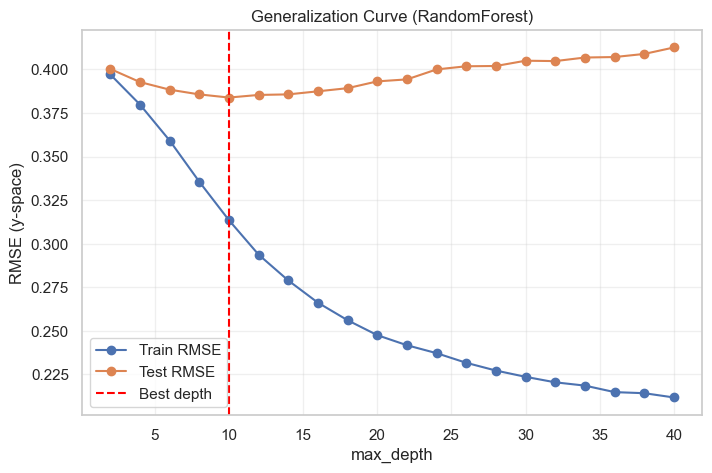

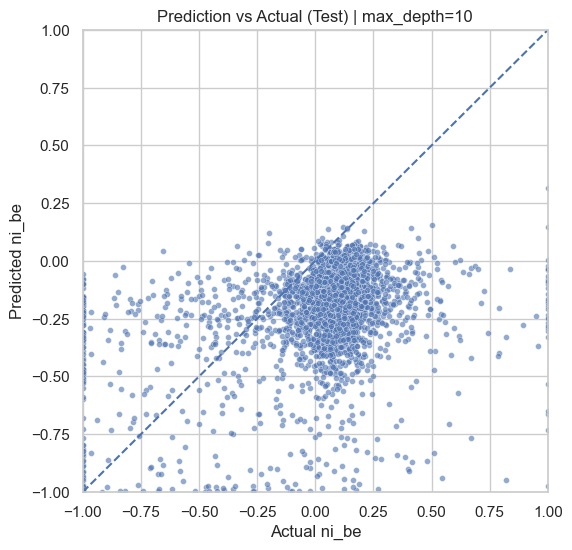

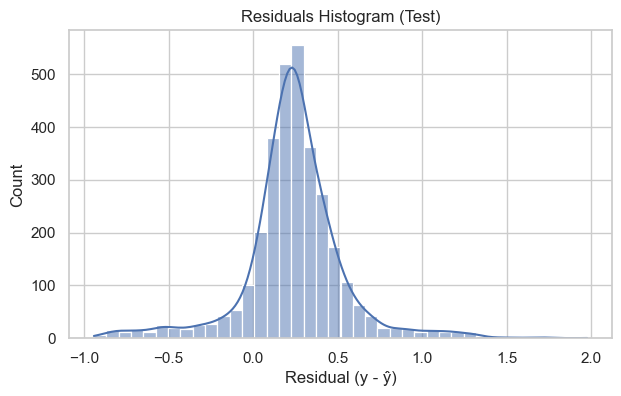

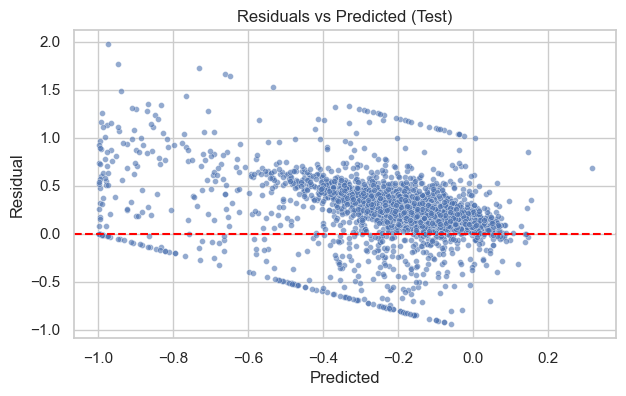

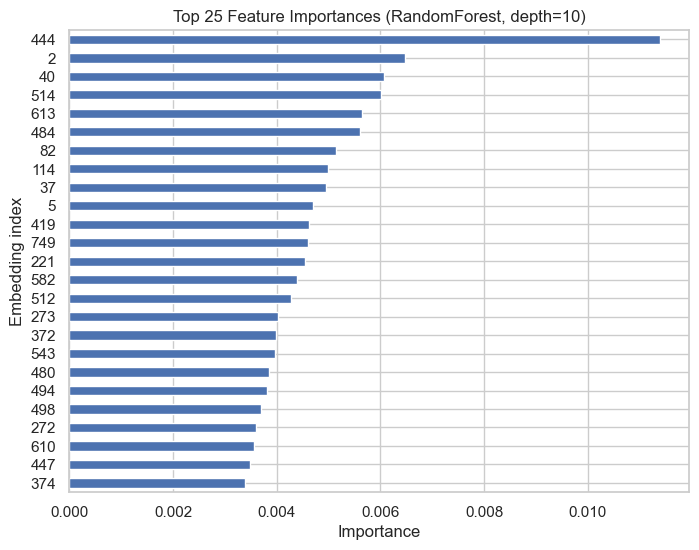

In [66]:
# 1. Generalization curve (Train vs Test RMSE)
train_rmses = [root_mean_squared_error(y_train, z_to_y(m["model"].predict(X_train))) for m in results]
test_rmses  = [m["test_rmse"] for m in results]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(depths, train_rmses, marker="o", label="Train RMSE")
ax.plot(depths, test_rmses,  marker="o", label="Test RMSE")
ax.axvline(best_depth, color="red", linestyle="--", label="Best depth")
ax.set_xlabel("max_depth")
ax.set_ylabel("RMSE (y-space)")
ax.set_title("Generalization Curve (RandomForest)")
ax.legend(); ax.grid(True, alpha=0.3)
plt.show()

# 2. Prediction vs Actual (Test)
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_te_pred, alpha=0.6, s=18, ax=ax)
lims = [-1, 1]
ax.plot(lims, lims, "--")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("Actual ni_be"); ax.set_ylabel("Predicted ni_be")
ax.set_title(f"Prediction vs Actual (Test) | max_depth={best_depth}")
plt.show()

# 3. Residual histogram
res = y_test - y_te_pred
fig, ax = plt.subplots(figsize=(7,4))
sns.histplot(res, bins=40, kde=True, ax=ax)
ax.set_title("Residuals Histogram (Test)")
ax.set_xlabel("Residual (y - ŷ)")
plt.show()

# 4. Residuals vs Predicted
fig, ax = plt.subplots(figsize=(7,4))
sns.scatterplot(x=y_te_pred, y=res, alpha=0.6, s=18, ax=ax)
ax.axhline(0, ls="--", color="red")
ax.set_title("Residuals vs Predicted (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")
plt.show()

# 5. Feature importances (Top 25)
imp = pd.Series(best_model.feature_importances_)
fig, ax = plt.subplots(figsize=(8,6))
imp.sort_values(ascending=False).head(25).iloc[::-1].plot(kind="barh", ax=ax)
ax.set_title(f"Top 25 Feature Importances (RandomForest, depth={best_depth})")
ax.set_xlabel("Importance")
ax.set_ylabel("Embedding index")
plt.show()


## Model 3 (HistGradientBoostingRegressor)

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt1
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.compose import TransformedTargetRegressor

sns.set(context="notebook", style="whitegrid")
RNG = 42

# ----- link transform to guarantee outputs in [-1, 1] -----
_EPS = 1e-6
def y_to_z(y):
    y_ = np.clip(y, -1 + _EPS, 1 - _EPS)
    return np.arctanh(y_)
def z_to_y(z):
    return np.clip(np.tanh(z), -1.0, 1.0)

# ----- pretty metrics -----
def report_metrics(y_true, y_pred, label=""):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    evs  = explained_variance_score(y_true, y_pred)
    print(f"{label}RMSE={rmse:.4f} | MAE={mae:.4f} | R^2={r2:.4f} | EVS={evs:.4f}")
    return dict(rmse=rmse, mae=mae, r2=r2, evs=evs)


In [68]:
# If you already have X_train, X_test, y_train, y_test defined, this cell will skip splitting.
if "X_train" not in globals():
    # Expect df with 'mgmt_embedding' (list[768]) and 'ni_be'
    X = np.vstack(df["mgmt_embedding"].values).astype(np.float32)
    y = df["ni_be"].to_numpy(np.float32)
    y = np.clip(y, -1, 1)  # enforce bounds for safety

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=RNG
    )

X_train.shape, X_test.shape


((24077, 768), (3174, 768))

In [69]:
kfold = KFold(n_splits=5, shuffle=True, random_state=RNG)

base = HistGradientBoostingRegressor(
    random_state=RNG,
    early_stopping=True,       # speed + generalization
    validation_fraction=0.15,
    n_iter_no_change=30,
    max_bins=255
)

# Wrap with target transform to enforce [-1,1] predictions
ttr = TransformedTargetRegressor(
    regressor=base,
    func=y_to_z,
    inverse_func=z_to_y
)

# Hyperparameter space (keep it reasonable for CPU)
param_dist = {
    "regressor__learning_rate":     np.geomspace(0.02, 0.2, 10),
    "regressor__max_depth":         [3, 5, 7, 9, 12, 15],
    "regressor__max_leaf_nodes":    [31, 63, 127, 255],
    "regressor__min_samples_leaf":  [5, 10, 20, 40, 80],
    "regressor__l2_regularization": np.geomspace(1e-6, 1e-2, 8),
    "regressor__max_iter":          [200, 300, 500],
}

search = RandomizedSearchCV(
    estimator=ttr,
    param_distributions=param_dist,
    n_iter=40,                                # adjust up if you want more search
    scoring="neg_root_mean_squared_error",    # scored in y-space thanks to TTR
    cv=kfold,
    n_jobs=-1,
    verbose=1,
    random_state=RNG,
    refit=True,                               # refit on full train with best params
    return_train_score=True,
)

search.fit(X_train, y_train)

print("Best CV RMSE:", -search.best_score_)
print("Best params:")
best_params = {k: v for k, v in search.best_params_.items()}
best_params


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning:

Best CV RMSE: 0.3884327218952727
Best params:


{'regressor__min_samples_leaf': 20,
 'regressor__max_leaf_nodes': 31,
 'regressor__max_iter': 200,
 'regressor__max_depth': 3,
 'regressor__learning_rate': np.float64(0.025830993300297683),
 'regressor__l2_regularization': np.float64(0.0026826957952797246)}

In [70]:
best_model = search.best_estimator_   # This is a TransformedTargetRegressor
y_tr_pred = best_model.predict(X_train)   # already mapped to [-1,1]
y_te_pred = best_model.predict(X_test)

print("== Regression metrics ==")
train_stats = report_metrics(y_train, y_tr_pred, "Train → ")
test_stats  = report_metrics(y_test,  y_te_pred, "Test  → ")


== Regression metrics ==
Train → RMSE=0.3686 | MAE=0.2866 | R^2=-0.2590 | EVS=0.1054
Test  → RMSE=0.3949 | MAE=0.3006 | R^2=-0.6881 | EVS=-0.1462


/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:213: UserWarning:

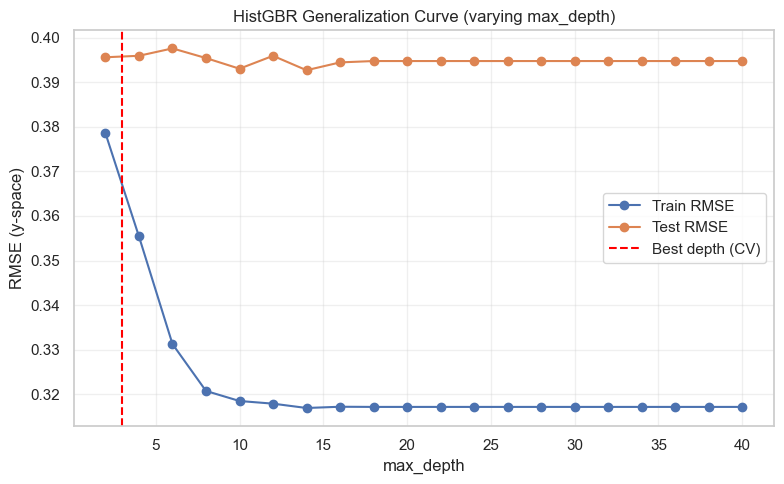

In [71]:
# Extract the best regressor params to reuse
reg_best = search.best_estimator_.regressor
fixed = reg_best.get_params()

depths = list(range(2, 42, 2))
gen = []

for d in depths:
    reg = HistGradientBoostingRegressor(**{**fixed, "max_depth": d})
    ttr_depth = TransformedTargetRegressor(regressor=reg, func=y_to_z, inverse_func=z_to_y)
    ttr_depth.fit(X_train, y_train)
    y_tr = ttr_depth.predict(X_train)
    y_te = ttr_depth.predict(X_test)
    gen.append({
        "max_depth": d,
        "train_rmse": root_mean_squared_error(y_train, y_tr),
        "test_rmse":  root_mean_squared_error(y_test,  y_te),
        "model": ttr_depth
    })

gen_df = pd.DataFrame(gen)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(gen_df["max_depth"], gen_df["train_rmse"], marker="o", label="Train RMSE")
ax.plot(gen_df["max_depth"], gen_df["test_rmse"],  marker="o", label="Test RMSE")
ax.axvline(reg_best.get_params().get("max_depth", None), color="red", ls="--", label="Best depth (CV)")
ax.set_xlabel("max_depth"); ax.set_ylabel("RMSE (y-space)")
ax.set_title("HistGBR Generalization Curve (varying max_depth)")
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


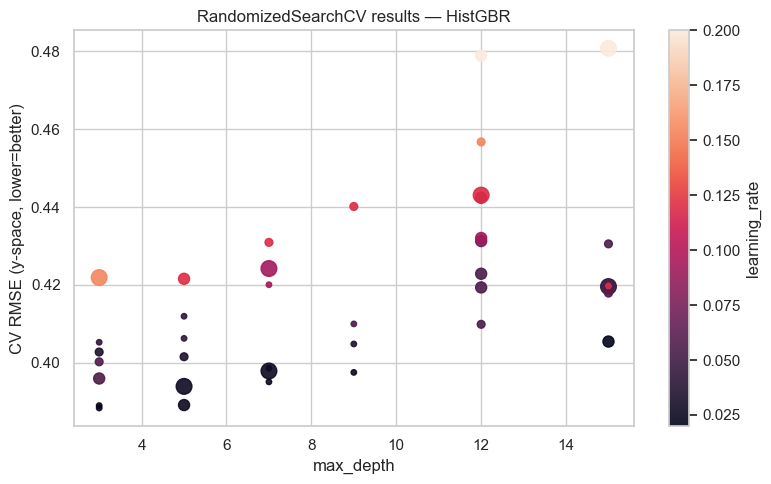

In [72]:
cvdf = pd.DataFrame(search.cv_results_)

# Scatter: mean CV RMSE vs max_depth (color=learning_rate, size=max_leaf_nodes)
fig, ax = plt.subplots(figsize=(8,5))
sc = ax.scatter(
    cvdf["param_regressor__max_depth"].astype(float),
    -cvdf["mean_test_score"],                    # positive RMSE
    c=cvdf["param_regressor__learning_rate"].astype(float),
    s=cvdf["param_regressor__max_leaf_nodes"].astype(float) / 2,
    alpha=0.9
)
ax.set_xlabel("max_depth"); ax.set_ylabel("CV RMSE (y-space, lower=better)")
ax.set_title("RandomizedSearchCV results — HistGBR")
cb = plt.colorbar(sc, ax=ax); cb.set_label("learning_rate")
plt.tight_layout(); plt.show()


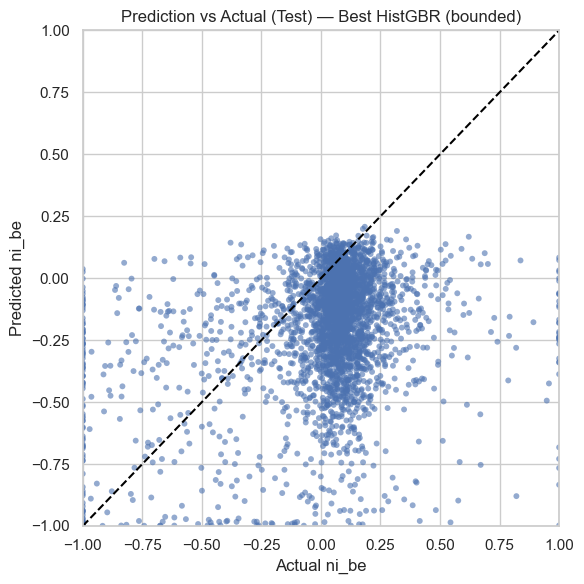

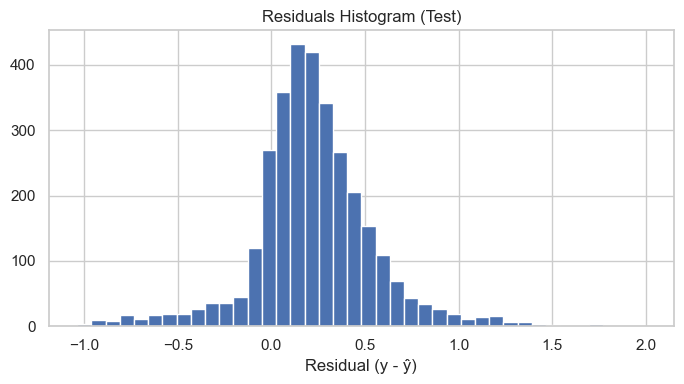

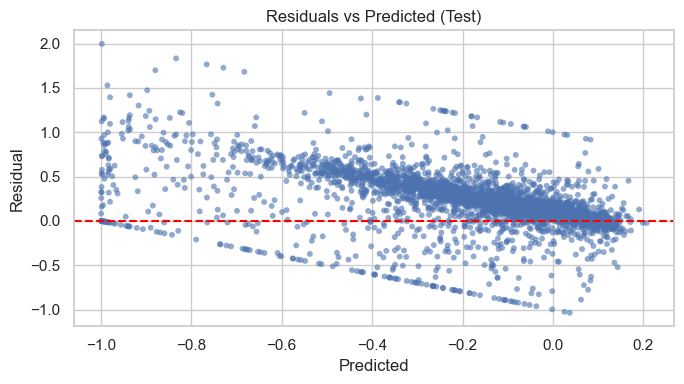

In [73]:
# Prediction vs Actual
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_test, y_te_pred, s=18, alpha=0.6, edgecolors="none")
lims = [-1, 1]
ax.plot(lims, lims, "--", color="black")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("Actual ni_be"); ax.set_ylabel("Predicted ni_be")
ax.set_title("Prediction vs Actual (Test) — Best HistGBR (bounded)")
plt.tight_layout(); plt.show()

# Residuals
res = y_test - y_te_pred
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(res, bins=40)
ax.set_title("Residuals Histogram (Test)")
ax.set_xlabel("Residual (y - ŷ)")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(y_te_pred, res, s=18, alpha=0.6, edgecolors="none")
ax.axhline(0.0, ls="--", color="red")
ax.set_title("Residuals vs Predicted (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")
plt.tight_layout(); plt.show()


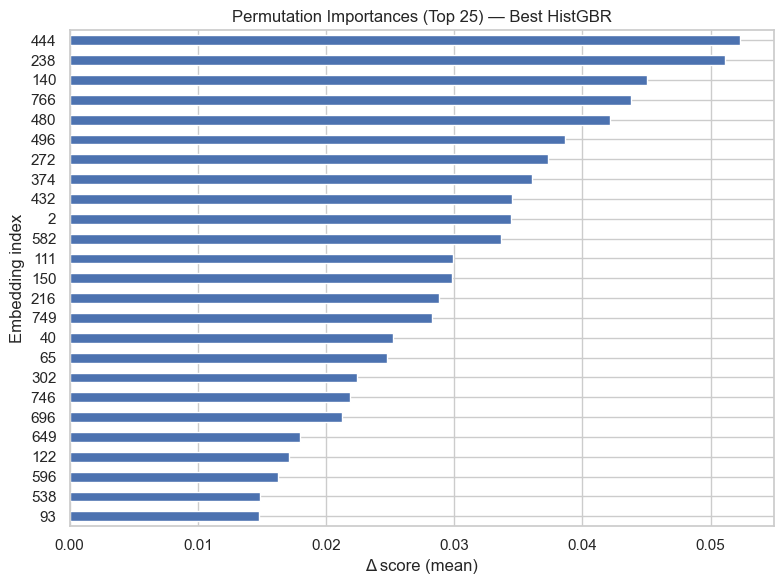

In [74]:
# Permutation importance runs on the wrapped estimator — scoring in y-space
pi = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=5, random_state=RNG, n_jobs=-1
)
imp = pd.Series(pi.importances_mean)

top_k = 25
fig, ax = plt.subplots(figsize=(8,6))
imp.sort_values(ascending=False).head(top_k).iloc[::-1].plot(kind="barh", ax=ax)
ax.set_title("Permutation Importances (Top 25) — Best HistGBR")
ax.set_xlabel("Δ score (mean)"); ax.set_ylabel("Embedding index")
plt.tight_layout(); plt.show()
